In [115]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import math
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, UpSampling2D, Concatenate, Dropout, Conv2DTranspose
from tensorflow.keras.backend import clear_session
from tensorflow.keras import backend as K

import warnings
warnings.filterwarnings("ignore")

In [116]:
input_path = os.path.join('Datasets','glaucoma_data','input')
output_path = os.path.join('Datasets','glaucoma_data','output')

X = list()
y = list()
total_images = len(os.listdir(input_path))
inp_list = os.listdir(input_path)
out_list = os.listdir(output_path)

for i in range(0,total_images):
    temp_input_im = os.path.join(input_path, inp_list[i])
    temp_output_im = os.path.join(output_path, out_list[i])
    X.append(cv2.imread(temp_input_im))
    y.append(cv2.imread(temp_output_im,cv2.IMREAD_GRAYSCALE))


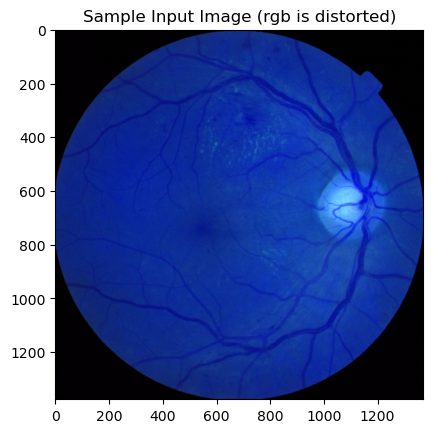

In [117]:
plt.title('Sample Input Image (rgb is distorted)')
plt.imshow(X[5])
plt.show()

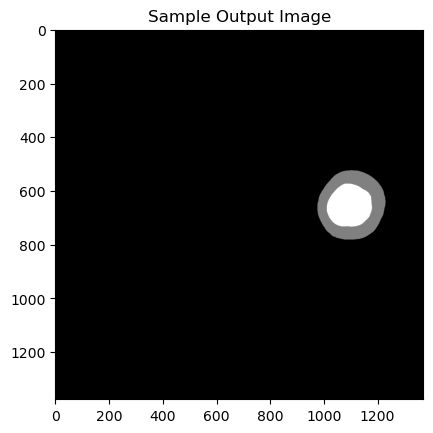

In [118]:
plt.title('Sample Output Image')
plt.imshow(y[5], cmap = 'gray')
plt.show()

### Preprocessing Pipelines

In [119]:
def inputPipeline(input_im): 
    transformed_im = cv2.resize(input_im,(256,256),interpolation=cv2.INTER_NEAREST)
    transformed_im = cv2.normalize(transformed_im,None,alpha = 0, beta =1,norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    
    return transformed_im
    
def outputPipeline_disc(output_im):
    transformed_im = cv2.resize(output_im,(256,256),interpolation=cv2.INTER_NEAREST)
    _,transformed_im = cv2.threshold(transformed_im,127,255,cv2.THRESH_BINARY)
    transformed_im = cv2.normalize(transformed_im, None,alpha=0,beta=1,norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    
    
    return transformed_im

def outputPipeline_cup(output_im):
    transformed_im = cv2.resize(output_im,(256,256),interpolation=cv2.INTER_NEAREST)
    _,transformed_im = cv2.threshold(transformed_im,254,255,cv2.THRESH_BINARY)
    transformed_im = cv2.normalize(transformed_im, None,alpha=0,beta=1,norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    
    
    return transformed_im


In [120]:
X = list(map(inputPipeline,X))
y_disc = list(map(outputPipeline_disc,y))
y_cup = list(map(outputPipeline_cup,y))

In [122]:
X = np.array(X)
y_disc = np.array(y_disc)
y_cup = np.array(y_cup)

y_disc = y_disc.reshape((y_disc.shape[0],y_disc.shape[1], y_disc.shape[2],1))
y_cup = y_cup.reshape((y_cup.shape[0],y_cup.shape[1], y_cup.shape[2],1))

## Train Test Split

In [123]:
from sklearn.model_selection import train_test_split
X_train_disc, X_test_disc, y_train_disc, y_test_disc = train_test_split(X,y_disc,test_size = 0.1,random_state = 42) #discs

X_train_cup, X_test_cup, y_train_cup, y_test_cup = train_test_split(X,y_cup,test_size = 0.1,random_state = 42) #cups

In [124]:
def create_model(input_size = (256,256,3)):
    
    clear_session()
    
    # Input layer
    inputs = Input(input_size)
    
    # Encoder (Contracting path)
    conv1 = Conv2D(8, (3,3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(8, (3,3), activation='relu', padding='same')(conv1)
    conv1 = Dropout(0.2)(conv1)
    conv1 = Conv2D(8, (3,3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(16, (3,3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(16, (3,3), activation='relu', padding='same')(conv2)
    conv2 = Dropout(0.2)(conv2)
    conv2 = Conv2D(16, (3,3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(32, (3,3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(32, (3,3), activation='relu', padding='same')(conv3)
    conv3 = Dropout(0.2)(conv3)
    conv3 = Conv2D(32, (3,3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    # Bottleneck
    conv4 = Conv2D(64, (3,3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(64, (3,3), activation='relu', padding='same')(conv4)
    conv4 = Dropout(0.2)(conv4)
    conv4 = Conv2D(64, (3,3), activation='relu', padding='same')(conv4)
    
    # Decoder (Expanding path)
    up5 = UpSampling2D()(conv4)
    up5 = Conv2DTranspose(32, (2,2), activation='relu', padding='same')(up5)
    up5 = Concatenate()([up5, conv3])
    conv5 = Conv2D(32, (3,3), activation='relu', padding='same')(up5)
    conv5 = Conv2D(32, (3,3), activation='relu', padding='same')(conv5)
    conv5 = Dropout(0.2)(conv5)
    conv5 = Conv2D(32, (3,3), activation='relu', padding='same')(conv5)
    
    up6 = UpSampling2D()(conv5)
    up6 = Conv2DTranspose(16, (2,2), activation='relu', padding='same')(up6)
    up6 = Concatenate()([up6, conv2])
    conv6 = Conv2D(16, (3,3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(16, (3,3), activation='relu', padding='same')(conv6)
    conv6 = Dropout(0.2)(conv6)
    conv6 = Conv2D(16, (3,3), activation='relu', padding='same')(conv6)
    
    up7 = UpSampling2D()(conv6)
    up7 = Conv2DTranspose(8, (2,2), activation='relu', padding='same')(up7)
    up7 = Concatenate()([up7, conv1])
    conv7 = Conv2D(8, (3,3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(8, (3,3), activation='relu', padding='same')(conv7)
    conv7 = Dropout(0.2)(conv7)
    conv7 = Conv2D(8, (3,3), activation='relu', padding='same')(conv7)
    
    # Output layer
    outputs = Conv2D(1, (1,1), activation='sigmoid')(conv7)
    
    model = Model(inputs=inputs, outputs=outputs)
    

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['recall','precision','accuracy'])
    
    
    return model

model_disc = create_model()
model_cup = create_model()

# The Disc Model

In [125]:
model_disc.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 256, 256, 8)       │             224 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 256, 256, 8)       │             584 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 256, 256, 8)       │               0 │ conv2d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 256, 256, 8)       │             584 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 128, 128, 8)       │               0 │ conv2d_2[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 128, 128, 16)      │           1,168 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 128, 128, 16)      │           2,320 │ conv2d_3[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 128, 128, 16)      │               0 │ conv2d_4[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, 128, 128, 16)      │           2,320 │ dropout_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 64, 64, 16)        │               0 │ conv2d_5[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_6 (Conv2D)             │ (None, 64, 64, 32)        │           4,640 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_7 (Conv2D)             │ (None, 64, 64, 32)        │           9,248 │ conv2d_6[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, 64, 64, 32)        │               0 │ conv2d_7[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_8 (Conv2D)             │ (None, 64, 64, 32)        │           9,248 │ dropout_2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_2               │ (None, 32, 32, 32)        │               0 │ conv2d_8[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 182,057 (711.16 KB)

 Trainable params: 182,057 (711.16 KB)

 Non-trainable params: 0 (0.00 B)

# The Cup Model

In [126]:
model_cup.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 256, 256, 8)       │             224 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 256, 256, 8)       │             584 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 256, 256, 8)       │               0 │ conv2d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 256, 256, 8)       │             584 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 128, 128, 8)       │               0 │ conv2d_2[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 128, 128, 16)      │           1,168 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 128, 128, 16)      │           2,320 │ conv2d_3[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 128, 128, 16)      │               0 │ conv2d_4[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, 128, 128, 16)      │           2,320 │ dropout_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 64, 64, 16)        │               0 │ conv2d_5[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_6 (Conv2D)             │ (None, 64, 64, 32)        │           4,640 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_7 (Conv2D)             │ (None, 64, 64, 32)        │           9,248 │ conv2d_6[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, 64, 64, 32)        │               0 │ conv2d_7[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_8 (Conv2D)             │ (None, 64, 64, 32)        │           9,248 │ dropout_2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_2               │ (None, 32, 32, 32)        │               0 │ conv2d_8[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 182,057 (711.16 KB)

 Trainable params: 182,057 (711.16 KB)

 Non-trainable params: 0 (0.00 B)

## Training Disc Model

In [138]:
history = model_disc.fit(X_train_disc,y_train_disc,validation_split=0.1,epochs = 100)

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 961ms/step - accuracy: 0.9808 - loss: 0.1154 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9814 - val_loss: 0.1315 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 943ms/step - accuracy: 0.9809 - loss: 0.1035 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9814 - val_loss: 0.1028 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 942ms/step - accuracy: 0.9808 - loss: 0.0955 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9814 - val_loss: 0.1210 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 969ms/step - accuracy: 0.9807 - loss: 0.0867 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9814 - val_loss: 0.1051 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 939ms/step - accuracy: 0.9809 - loss: 0.0793 - precision: 0.

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 945ms/step - accuracy: 0.9807 - loss: 0.0405 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9814 - val_loss: 0.0404 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 33/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 974ms/step - accuracy: 0.9806 - loss: 0.0367 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9814 - val_loss: 0.0343 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 34/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 943ms/step - accuracy: 0.9808 - loss: 0.0355 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9814 - val_loss: 0.0342 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 35/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 945ms/step - accuracy: 0.9810 - loss: 0.0331 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9814 - val_loss: 0.0324 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 36/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 949ms/step - accuracy: 0.9809 - loss: 0.0330 - precision: 0.0000e+00

Epoch 64/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 949ms/step - accuracy: 0.9807 - loss: 0.0179 - precision: 0.5586 - recall: 2.3586e-04 - val_accuracy: 0.9814 - val_loss: 0.0306 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 65/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 971ms/step - accuracy: 0.9810 - loss: 0.0182 - precision: 0.4954 - recall: 3.1521e-04 - val_accuracy: 0.9814 - val_loss: 0.0324 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 66/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 953ms/step - accuracy: 0.9808 - loss: 0.0181 - precision: 0.5447 - recall: 6.5646e-04 - val_accuracy: 0.9814 - val_loss: 0.0438 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 67/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 952ms/step - accuracy: 0.9808 - loss: 0.0177 - precision: 0.6972 - recall: 7.8505e-04 - val_accuracy: 0.9814 - val_loss: 0.0363 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 68/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 953ms/step - accuracy: 0.9808 - loss: 0.0176 - precision: 0.7398 - reca

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 955ms/step - accuracy: 0.9951 - loss: 0.0169 - precision: 0.9728 - recall: 0.7638 - val_accuracy: 0.9905 - val_loss: 0.0415 - val_precision: 0.9930 - val_recall: 0.4927
Epoch 98/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 973ms/step - accuracy: 0.9950 - loss: 0.0168 - precision: 0.9725 - recall: 0.7602 - val_accuracy: 0.9905 - val_loss: 0.0403 - val_precision: 0.9974 - val_recall: 0.4875
Epoch 99/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 946ms/step - accuracy: 0.9954 - loss: 0.0165 - precision: 0.9770 - recall: 0.7744 - val_accuracy: 0.9921 - val_loss: 0.0266 - val_precision: 0.9962 - val_recall: 0.5785
Epoch 100/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 948ms/step - accuracy: 0.9961 - loss: 0.0167 - precision: 0.9714 - recall: 0.8184 - val_accuracy: 0.9909 - val_loss: 0.0322 - val_precision: 1.0000 - val_recall: 0.5094


## Training Cup Model

In [147]:
history = model_cup.fit(X_train_cup,y_train_cup,validation_split=0.1,epochs = 20)

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 983ms/step - accuracy: 0.9948 - loss: 0.0056 - precision: 0.4889 - recall: 0.0019 - val_accuracy: 0.9953 - val_loss: 0.0054 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 964ms/step - accuracy: 0.9946 - loss: 0.0058 - precision: 0.6170 - recall: 0.0026 - val_accuracy: 0.9953 - val_loss: 0.0054 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 943ms/step - accuracy: 0.9947 - loss: 0.0056 - precision: 0.6064 - recall: 0.0025 - val_accuracy: 0.9953 - val_loss: 0.0053 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 942ms/step - accuracy: 0.9947 - loss: 0.0056 - precision: 0.4361 - recall: 0.0021 - val_accuracy: 0.9953 - val_loss: 0.0054 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 964ms/step - accuracy: 0.9947 - loss: 0.0055 - precision: 0.5706 - recall: 0.0027 - val_accuracy:

## Evaluating Models

In [155]:
model_disc.evaluate(X_test_disc,y_test_disc)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9914 - loss: 0.0372 - precision: 0.9999 - recall: 0.5472


[0.03723377734422684,
 0.5472061634063721,
 0.9998533129692078,
 0.9913924932479858]

In [156]:
model_cup.evaluate(X_test_cup,y_test_cup)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9981 - loss: 0.0067 - precision: 0.8338 - recall: 0.7881


[0.006706269923597574,
 0.7880931496620178,
 0.8338010311126709,
 0.998089611530304]

## Pipelining Models

In [223]:
def generate_prediction(sample_im):
    sample_im = sample_im.reshape(1, sample_im.shape[0], sample_im.shape[1], sample_im.shape[2])
    
    disc_region = model_disc.predict(sample_im)
    disc_region = disc_region[0]
    
    _,disc_region = cv2.threshold(disc_region,0.2,0.5,cv2.THRESH_BINARY)
    
    cup_region = model_cup.predict(sample_im)
    cup_region = cup_region[0]
    
    _,cup_region = cv2.threshold(cup_region, 0.2,1,cv2.THRESH_BINARY)
    
    ret_im = np.zeros(shape = (256,256,1))
    
    for r in range(256): # there is probably a simpler way to do this but I am lazy at this point
        for c in range(256):
            if(cup_region[r,c]==1):
                ret_im[r,c] = cup_region[r,c]
            else:
                 ret_im[r,c] = disc_region[r,c]
                    
    return ret_im

# Final Result

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


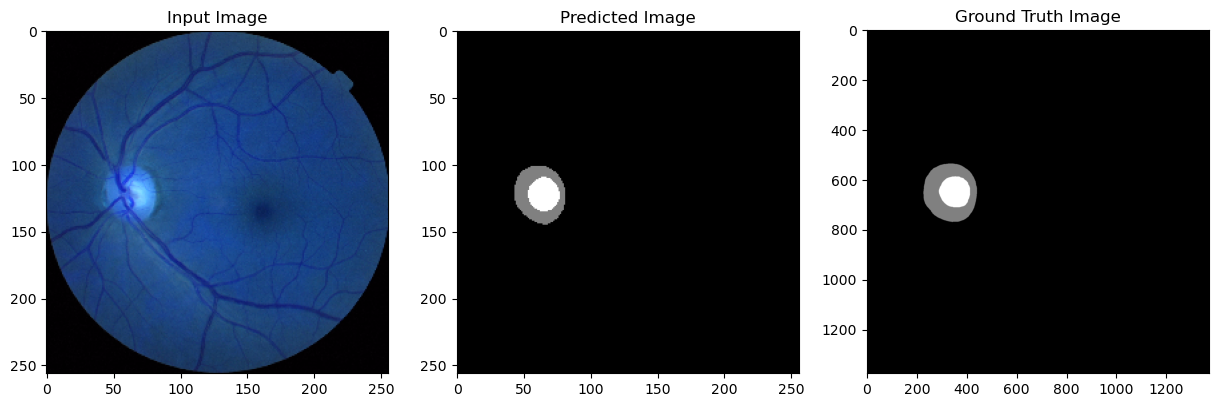

In [258]:
check_num = 9

pred_im = generate_prediction(X[check_num]) 

fig, axs = plt.subplots(1, 3, figsize=(15, 5))


axs[0].set_title('Input Image')
axs[0].imshow(X[check_num])

axs[1].set_title('Predicted Image')
axs[1].imshow(pred_im, cmap="gray")

axs[2].set_title('Ground Truth Image')
axs[2].imshow(y[check_num], cmap="gray")

plt.show()
